In [1]:
@info pwd()
import Pkg.activate as pactivate
pactivate("../../")
JULIA_DEBUG=Main
using Plots, Statistics, DelimitedFiles, Unitful
pyplot()

[ Info: /Users/jun/codes/SPM.jl/test/notebooks
  Activating project at `~/codes/SPM.jl`


Plots.PyPlotBackend()

In [77]:
include("../../src/SPM.jl")

Main.SPM

[ Info: (10, 10)
[ Info: (30, 30)
[ Info: Matrix{Float32}


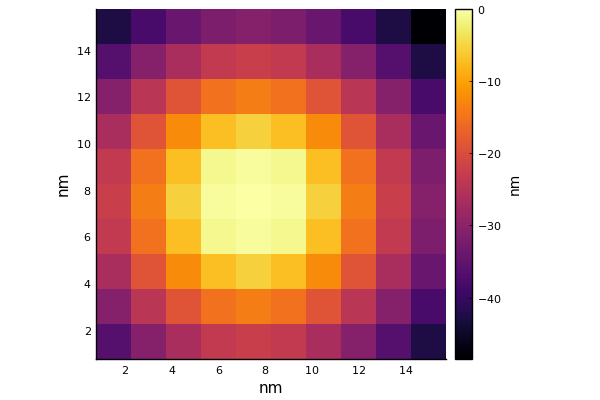

In [12]:
using BSON: @load
@load "../data/single_tip_test_data.bson" resolution tip surfs images images_randn
resolution = resolution / 10.0 # 解像度[nm/px]
# 変換、画素値は\AAからnmに変換
surfs = [SPM.Image(mat/10.0, resolution) for mat in surfs] # 実表面
images = [SPM.Image(mat/10.0, resolution) for mat in images] # ノイズなし画像
noisy_images = [SPM.Image(mat/10.0, resolution) for mat in images_randn] # ノイズあり画像
true_tip = SPM.Tip(tip/10.0, resolution) # 探針

noisy_images = noisy_images[1:9]

@info size(true_tip.data)
@info size(images[1].data)
@info typeof(images[1].data)
SPM.Plots.heatmap(true_tip)

[ Info: (30, 30)


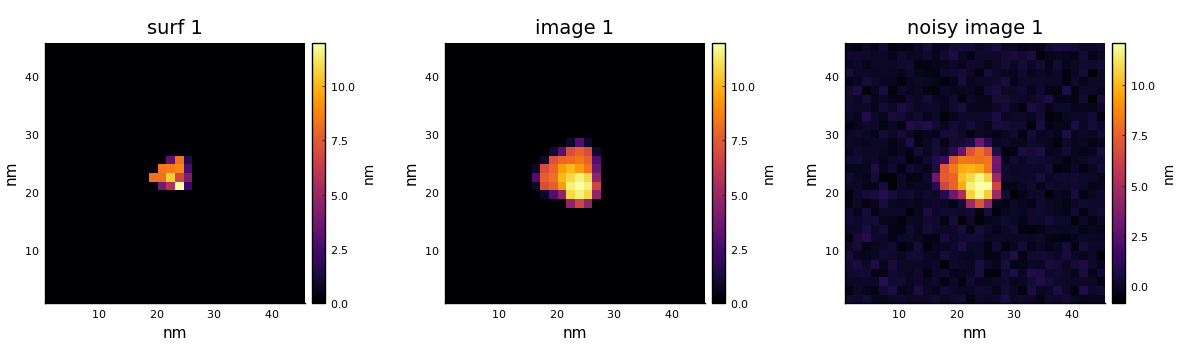

In [7]:
ps = Vector{Plots.Plot}(undef, 3)
for i in 0:0
    ps[3i+1] = SPM.Plots.heatmap(surfs[i+1]; title="surf $(i+1)")
    ps[3i+2] = SPM.Plots.heatmap(images[i+1]; title="image $(i+1)")
    ps[3i+3] = SPM.Plots.heatmap(noisy_images[i+1]; title="noisy image $(i+1)")
end
@info size(images[1].data)
plot(ps..., layout=(1,3), size=(1200, 360))

In [24]:
downscale_ratio = 1
tip_size = div(size(true_tip.data, 1), downscale_ratio)
max_epoch = 100
lambdas = [1.0e-10, 1e-8, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0, 5]
# lambdas = [1.0e-10, 1e-4, 1e-2, 1e-0]
@time results = SPM.BTR.solveDifferentiableBTR(
    noisy_images, tip_size, max_epoch, lambdas; downscale_ratio=downscale_ratio, debug_interval=0
)
df_images = [
    SPM.Image(image.data, image.resolution; datatype=Float64)
    for image in noisy_images
]
@info typeof(results[1].tip.data)
@time df_results = SPM.BTR.solveDifferentiableBTR(
    df_images, tip_size, max_epoch, lambdas; downscale_ratio=downscale_ratio, debug_interval=0
)

@info typeof(df_results[1].tip.data)

[ Info: 1th thread : start solving for lambda = 1.0
[ Info: 3th thread : start solving for lambda = 0.01
[ Info: 4th thread : start solving for lambda = 1.0e-10
[ Info: 2th thread : start solving for lambda = 0.0001
[ Info: 2th thread : optimizer setup completed
[ Info: 3th thread : optimizer setup completed
[ Info: 4th thread : optimizer setup completed
[ Info: 1th thread : optimizer setup completed
[ Info: 2th thread : 100th epoch completed in 1.307 sec
[ Info: 4th thread : 1th lambda completed
[ Info: 3th thread : start solving for lambda = 1.0e-8
[ Info: 2th thread : optimizer setup completed
[ Info: 1th thread : 100th epoch completed in 1.309 sec
[ Info: 3th thread : 4th lambda completed
[ Info: 4th thread : start solving for lambda = 0.001
[ Info: 4th thread : optimizer setup completed
[ Info: 2th thread : 100th epoch completed in 1.31 sec
[ Info: 3th thread : 6th lambda completed
[ Info: 4th thread : start solving for lambda = 0.1
[ Info: 1th thread : optimizer setup completed
[

  3.113616 seconds (4.84 M allocations: 1.639 GiB, 21.55% gc time)


[ Info: 3th thread : 100th epoch completed in 0.411 sec
[ Info: 3th thread : 3th lambda completed
[ Info: Matrix{Float32}
[ Info: 3th thread : start solving for lambda = 0.0001
[ Info: 1th thread : start solving for lambda = 1.0
[ Info: 2th thread : start solving for lambda = 0.01
[ Info: 4th thread : start solving for lambda = 1.0e-10
[ Info: 1th thread : optimizer setup completed
[ Info: 4th thread : optimizer setup completed
[ Info: 2th thread : optimizer setup completed
[ Info: 3th thread : optimizer setup completed
[ Info: 4th thread : 100th epoch completed in 1.85 sec
[ Info: 3th thread : 1th lambda completed
[ Info: 2th thread : start solving for lambda = 1.0e-8
[ Info: 4th thread : 100th epoch completed in 1.851 sec
[ Info: 2th thread : 4th lambda completed
[ Info: 1th thread : optimizer setup completed
[ Info: 1th thread : start solving for lambda = 0.001
[ Info: 2th thread : optimizer setup completed
[ Info: 3th thread : 100th epoch completed in 1.856 sec
[ Info: 3th thread :

  3.681068 seconds (4.84 M allocations: 2.348 GiB, 32.36% gc time)


[ Info: 4th thread : 100th epoch completed in 0.438 sec
[ Info: 4th thread : 3th lambda completed
[ Info: Matrix{Float64}


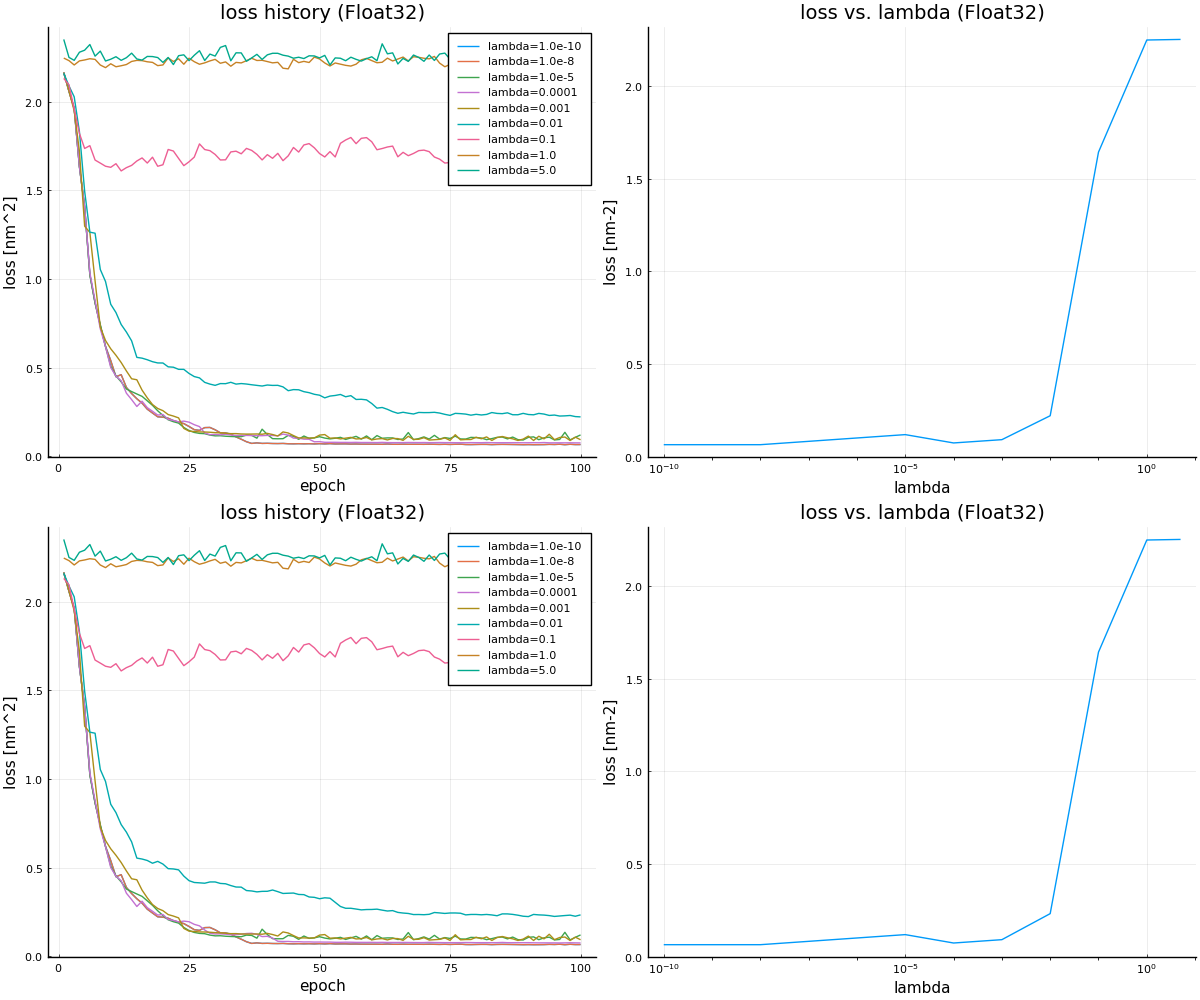

In [28]:
ps = Vector{Plots.Plot}(undef, 4)

ps[1] = plot(xlabel="epoch", ylabel="loss [nm^2]", title="loss history (Float32)")
for it in eachindex(lambdas)
    plot!(ps[1], collect(1:max_epoch), results[it].loss_history, label="lambda=$(lambdas[it])")
end

ps[2] = plot(
    lambdas, [result.loss_history[end] for result in results],
    xaxis=:log, xlabel="lambda", ylabel="loss [nm-2]", title="loss vs. lambda (Float32)", legend=nothing
)

ps[3] = plot(xlabel="epoch", ylabel="loss [nm^2]", title="loss history (Float32)")
for it in eachindex(lambdas)
    plot!(ps[3], collect(1:max_epoch), df_results[it].loss_history, label="lambda=$(lambdas[it])")
end

ps[4] = plot(
    lambdas, [result.loss_history[end] for result in df_results],
    xaxis=:log, xlabel="lambda", ylabel="loss [nm-2]", title="loss vs. lambda (Float32)", legend=nothing
)

plot(ps..., layout=(2,2), size=(1200, 1000))

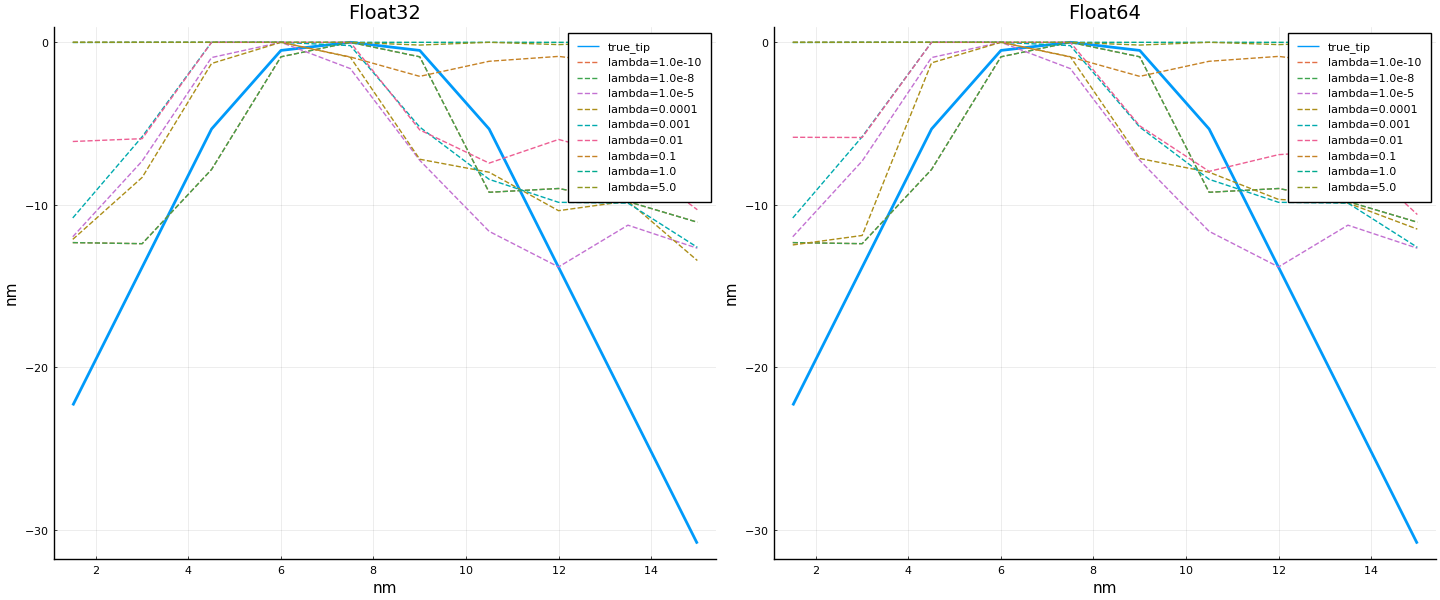

In [29]:
slice_direction = :x
i_slice = div(size(results[1].tip.data,1), 2) 
p = SPM.Plots.plotProfile(true_tip, slice_direction, i_slice; linewidth=2, label="true_tip", title="Float32")
for result in results
    p = SPM.Plots.plotProfile!(p, result.tip, slice_direction, i_slice; linestyle=:dash, label="lambda=$(result.lambda)")
end

df_p = SPM.Plots.plotProfile(true_tip, slice_direction, i_slice; linewidth=2, label="true_tip", title="Float64")
for result in df_results
    df_p = SPM.Plots.plotProfile!(df_p, result.tip, slice_direction, i_slice; linestyle=:dash, label="lambda=$(result.lambda)")
end

plot(p, df_p, layout=(1,2), size=(1440, 600))

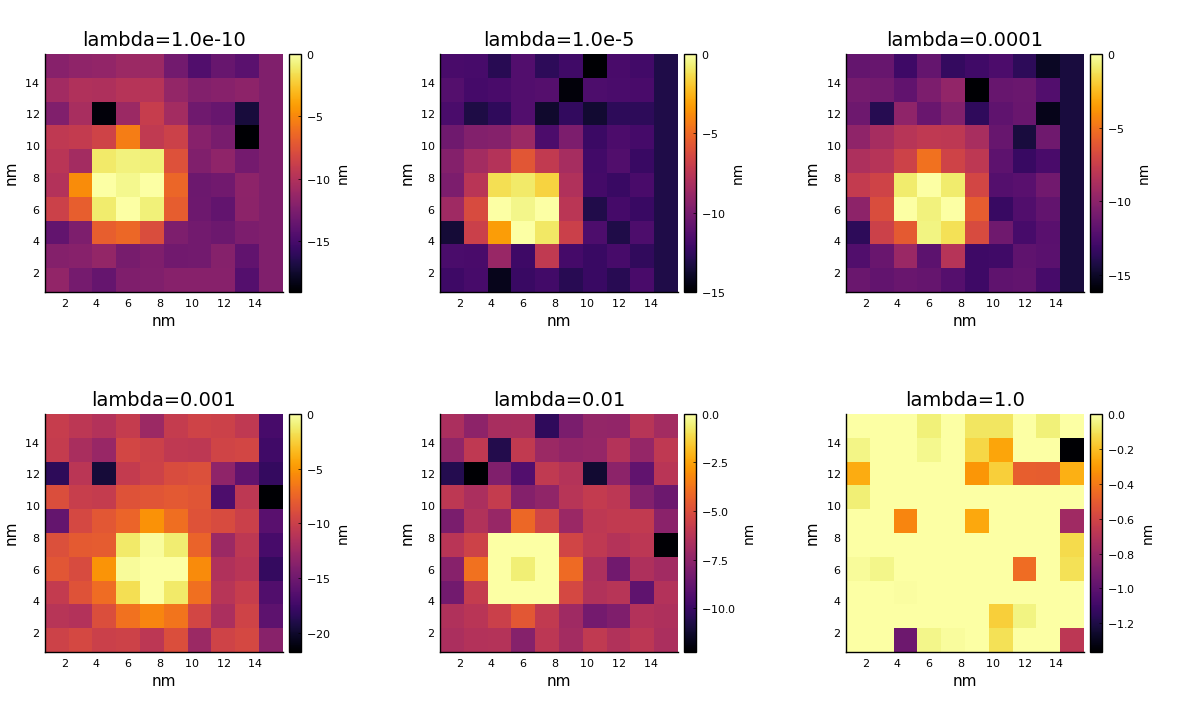

In [30]:
ps = Vector{Plots.Plot}(undef, 6)
# ps[1] = SPM.Plots.heatmap(true_tip; title="true tip")
for (i, i_lambda) in zip(1:6, [1,3,4,5,6,8])
    result = results[i_lambda]
    ps[i] = SPM.Plots.heatmap(result.tip; title="lambda=$(result.lambda)")
end
plot(ps..., layout=(2,3), size=(1200, 720))

[ Info: size:(512, 512)   resolution:0.1953125
[ Info: Matrix{Float32}


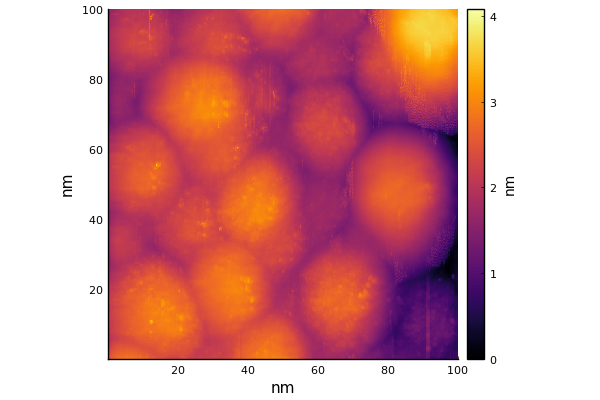

In [38]:
image = SPM.HDR.loadHDR("../data/B3446.hdr")
@info "size:$(size(image.data))   resolution:$(image.resolution)"
@info typeof(image.data)
SPM.Plots.heatmap(image; legend=true)

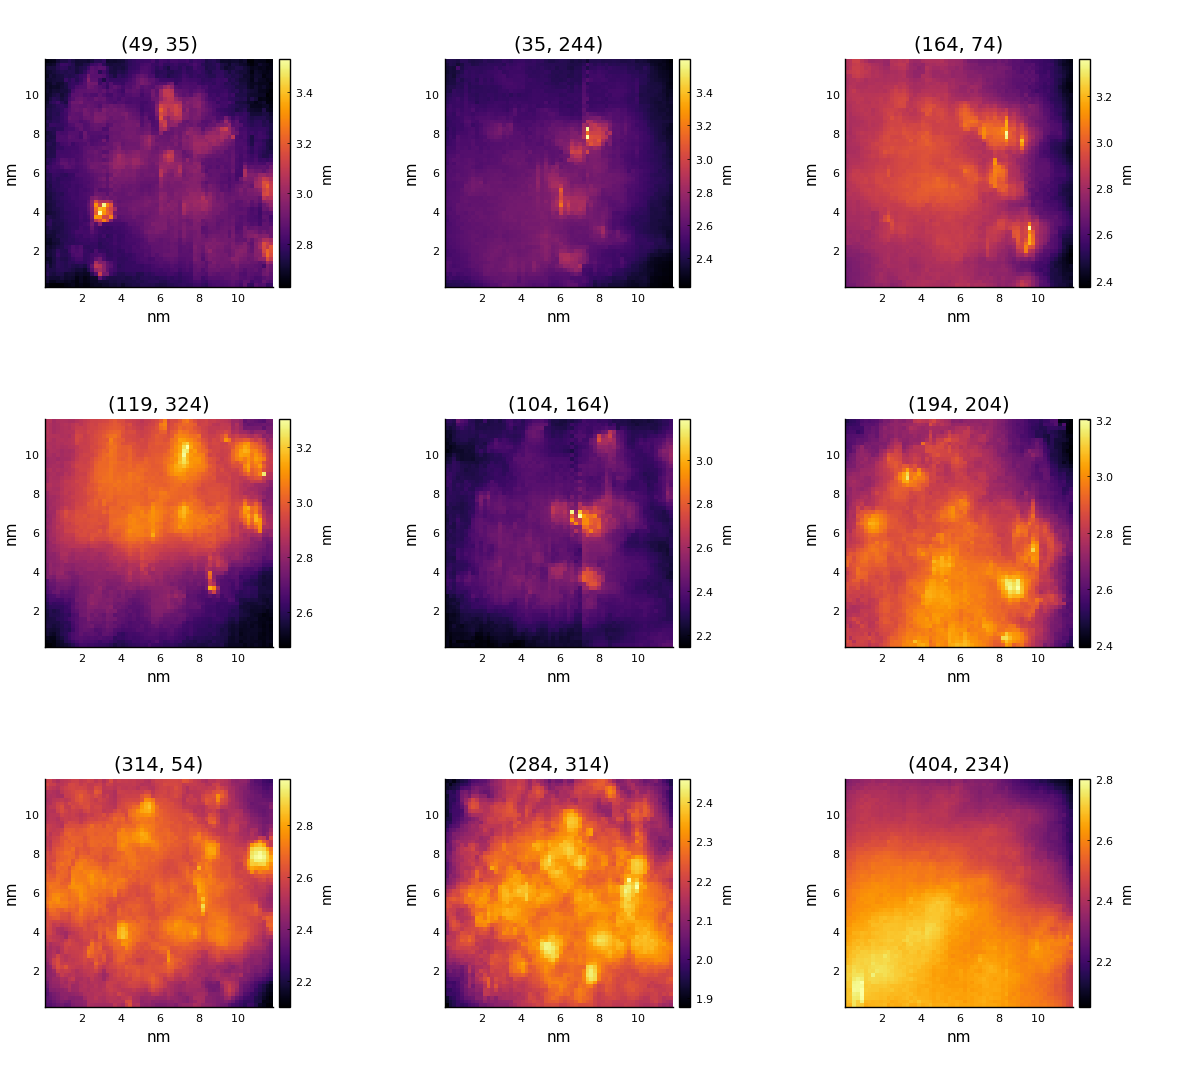

In [39]:
halfwidth = 30
extract_size = (2*halfwidth, 2*halfwidth)
centers = [
    (79,65), (65,274), (194, 104), 
    (149,354), (134,194), (224,234), 
    (344,84), (314,344), (434,264)
]
lowerlefts = [(p[1]-halfwidth, p[2]-halfwidth) for p in centers]
plots = Vector{Plots.Plot}(undef, length(lowerlefts))
extracted_images = SPM.extract(image, lowerlefts, extract_size)
for i = eachindex(lowerlefts)
    plots[i] = SPM.Plots.heatmap(extracted_images[i]; title="$(lowerlefts[i])", legend=true)
end

plot(plots..., layout=(3,3), size=(1200, 1080))

In [41]:
# lambdas = [1.0e-11, 1.0e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
lambdas = [1.0e-11, 1e-7, 1e-4, 1e-1]

4-element Vector{Float64}:
 1.0e-11
 1.0e-7
 0.0001
 0.1

In [40]:
downscale_ratio = 1
tip_size = 20
max_epoch = 200
@time normalResults = SPM.BTR.solveDifferentiableBTR(
    extracted_images, tip_size, max_epoch, lambdas; downscale_ratio=downscale_ratio, debug_interval=50
)
@info "finished"
# SPM.BTR.saveResults(extracted_images, normalResults, "normalResults")

[ Info: 1th thread : start solving for lambda = 1.0e-7
[ Info: 3th thread : start solving for lambda = 0.0001
[ Info: 4th thread : start solving for lambda = 0.1
[ Info: 2th thread : start solving for lambda = 1.0e-11
[ Info: 3th thread : optimizer setup completed
[ Info: 2th thread : optimizer setup completed
[ Info: 4th thread : optimizer setup completed
[ Info: 1th thread : optimizer setup completed
[ Info: 2th thread : 50th epoch completed in 7.128 sec
[ Info: 1th thread : 50th epoch completed in 7.205 sec
[ Info: 3th thread : 50th epoch completed in 7.263 sec
[ Info: 4th thread : 50th epoch completed in 7.298 sec
[ Info: 2th thread : 100th epoch completed in 14.219 sec
[ Info: 3th thread : 100th epoch completed in 14.438 sec
[ Info: 3th thread : 100th epoch completed in 14.464 sec
[ Info: 3th thread : 100th epoch completed in 14.582 sec
[ Info: 1th thread : 150th epoch completed in 20.977 sec
[ Info: 1th thread : 150th epoch completed in 21.154 sec
[ Info: 2th thread : 150th epoch

 28.321411 seconds (8.70 M allocations: 8.855 GiB, 12.50% gc time)


[ Info: 3th thread : 200th epoch completed in 28.318 sec
[ Info: 3th thread : 4th lambda completed


true

In [42]:
downscale_ratio = 2
tip_size = 20
max_epoch = 200
@time downScaledResults = SPM.BTR.solveDifferentiableBTR(
    extracted_images, tip_size, max_epoch, lambdas; downscale_ratio=downscale_ratio, debug_interval=50
)
@info "finished"
# SPM.BTR.saveResults(extracted_images, downScaledResults, "downScaledResults")

[ Info: 3th thread : start solving for lambda = 1.0e-7
[ Info: 2th thread : start solving for lambda = 1.0e-11
[ Info: 1th thread : start solving for lambda = 0.1
[ Info: 4th thread : start solving for lambda = 0.0001
[ Info: 3th thread : optimizer setup completed
[ Info: 4th thread : optimizer setup completed
[ Info: 2th thread : optimizer setup completed
[ Info: 1th thread : optimizer setup completed
[ Info: 4th thread : 50th epoch completed in 22.099 sec
[ Info: 4th thread : 50th epoch completed in 22.146 sec
[ Info: 2th thread : 50th epoch completed in 22.185 sec
[ Info: 4th thread : 50th epoch completed in 22.54 sec
[ Info: 4th thread : 100th epoch completed in 44.723 sec
[ Info: 2th thread : 100th epoch completed in 44.835 sec
[ Info: 4th thread : 100th epoch completed in 45.016 sec
[ Info: 1th thread : 100th epoch completed in 45.225 sec
[ Info: 3th thread : 150th epoch completed in 66.741 sec
[ Info: 1th thread : 150th epoch completed in 67.074 sec
[ Info: 3th thread : 150th ep

 89.295563 seconds (25.98 M allocations: 25.851 GiB, 9.40% gc time)


[ Info: 3th thread : 200th epoch completed in 89.29 sec
[ Info: 3th thread : 4th lambda completed


true

In [43]:
downscale_ratio = 1
tip_size = 40
max_epoch = 200
@time largeGridResults = SPM.BTR.solveDifferentiableBTR(
    extracted_images, tip_size, max_epoch, lambdas; downscale_ratio=downscale_ratio, debug_interval=50
)
@info "finished"
# SPM.BTR.saveResults(extracted_images, largeGridResults, "largeGridResults")

[ Info: 4th thread : start solving for lambda = 0.1
[ Info: 3th thread : start solving for lambda = 0.0001
[ Info: 2th thread : start solving for lambda = 1.0e-11
[ Info: 1th thread : start solving for lambda = 1.0e-7
[ Info: 4th thread : optimizer setup completed
[ Info: 1th thread : optimizer setup completed
[ Info: 2th thread : optimizer setup completed
[ Info: 3th thread : optimizer setup completed
[ Info: 3th thread : 50th epoch completed in 23.938 sec
[ Info: 1th thread : 50th epoch completed in 23.96 sec
[ Info: 4th thread : 50th epoch completed in 23.969 sec
[ Info: 3th thread : 50th epoch completed in 24.138 sec
[ Info: 3th thread : 100th epoch completed in 47.155 sec
[ Info: 4th thread : 100th epoch completed in 47.204 sec
[ Info: 2th thread : 100th epoch completed in 47.605 sec
[ Info: 1th thread : 100th epoch completed in 47.765 sec
[ Info: 1th thread : 150th epoch completed in 70.238 sec
[ Info: 4th thread : 150th epoch completed in 70.7 sec
[ Info: 1th thread : 150th epoc

 94.239526 seconds (25.98 M allocations: 76.654 GiB, 12.08% gc time)


[ Info: 4th thread : 200th epoch completed in 94.234 sec
[ Info: 4th thread : 4th lambda completed


4-element Vector{Main.SPM.BTR.DifferentiableBTRResult}:
 Main.SPM.BTR.DifferentiableBTRResult(1.0e-11, 200, Main.SPM.SPMCore.Tip(Float32[-9.194109 -9.492044 … -19.398056 -27.412863; -4.9259644 -7.47707 … -19.398056 -27.412863; … ; -4.952095 -4.9521284 … -19.398056 -27.412863; -17.252657 -17.252657 … -19.398056 -27.412863], 0.1953125), Main.SPM.SPMCore.Tip(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], 0.1953125), [0.014444742351770401, 0.014257444068789482, 0.013998637907207012, 0.013696081936359406, 0.013200243003666401, 0.012770288623869419, 0.012507420033216476, 0.012370102107524872, 0.012154258787631989, 0.011920914053916931  …  0.017407068982720375, 0.017407068982720375, 0.017407068982720375, 0.017407068982720375, 0.017407068982720375, 0.017407068982720375, 0.017407068982720375, 0.017407068982720375, 0.017407068982720375, 0.017407068982720375])
 Main.SPM.BTR.DifferentiableBTRResult(1.0e-7, 200, Main.SPM.SPMCore.Tip(Float32[-9.192482 -9.490

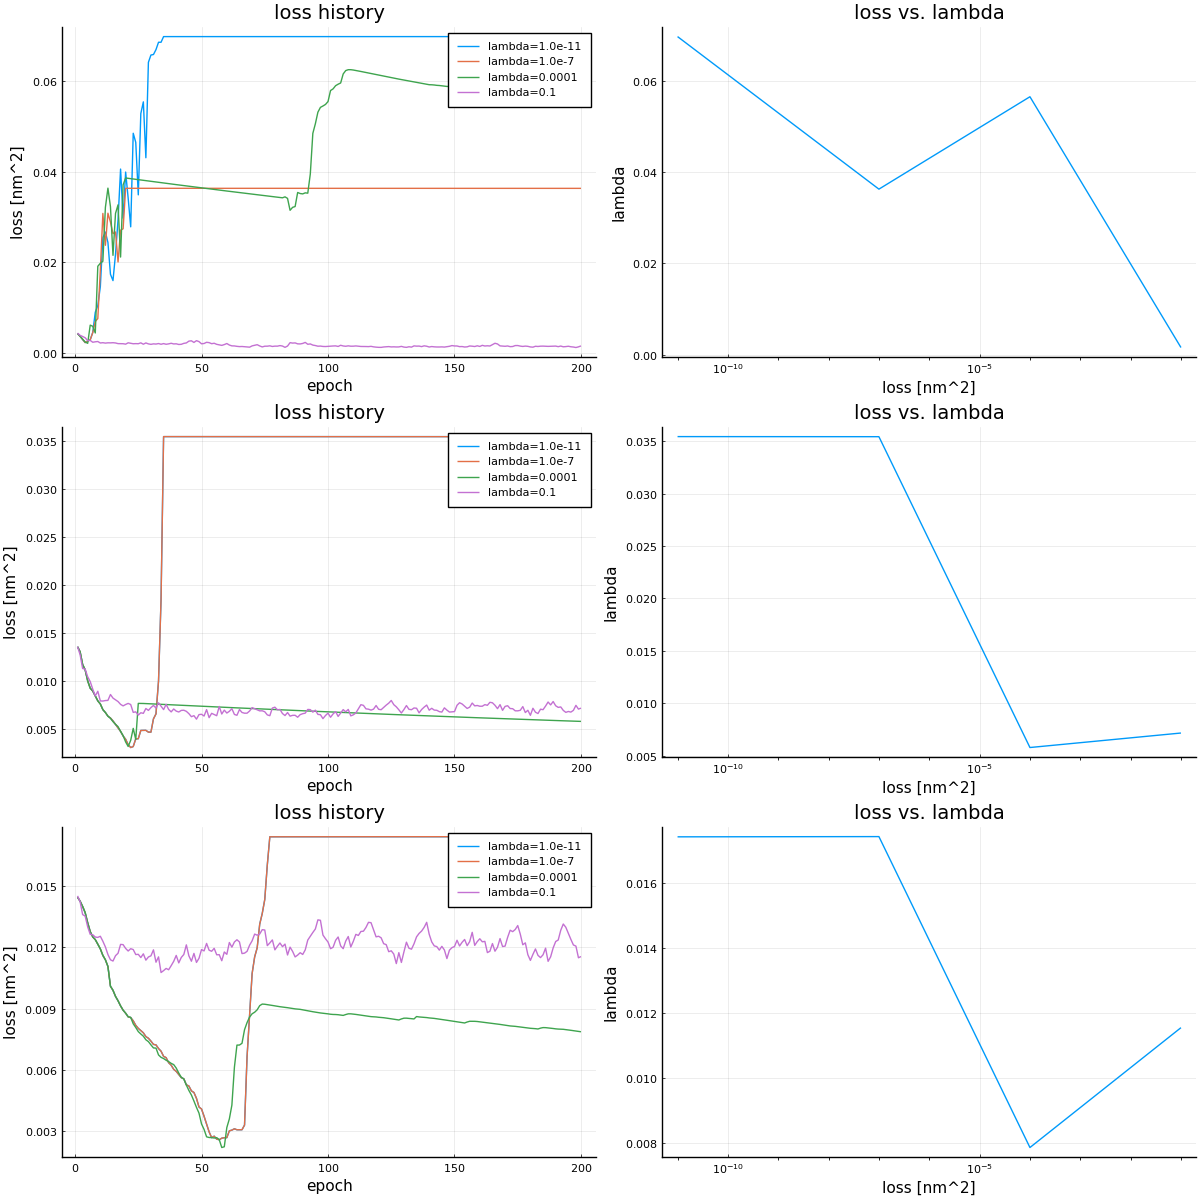

In [44]:
ps = Vector{Plots.Plot}(undef, 6)

for (i, results) in enumerate([normalResults, downScaledResults, largeGridResults])
    ps[2*i-1] = plot(xlabel="epoch", ylabel="loss [nm^2]", title="loss history")
    max_epoch = results[1].max_epoch
    for it in eachindex(lambdas)
        plot!(ps[2*i-1], collect(1:max_epoch), results[it].loss_history, label="lambda=$(lambdas[it])")
    end

    ps[2*i] = plot(
        lambdas, [result.loss_history[end] for result in results],
        xaxis=:log, xlabel="loss [nm^2]", ylabel="lambda", title="loss vs. lambda", legend=nothing
    )
end

plot(ps..., layout=(3,2), size=(1200, 1200))

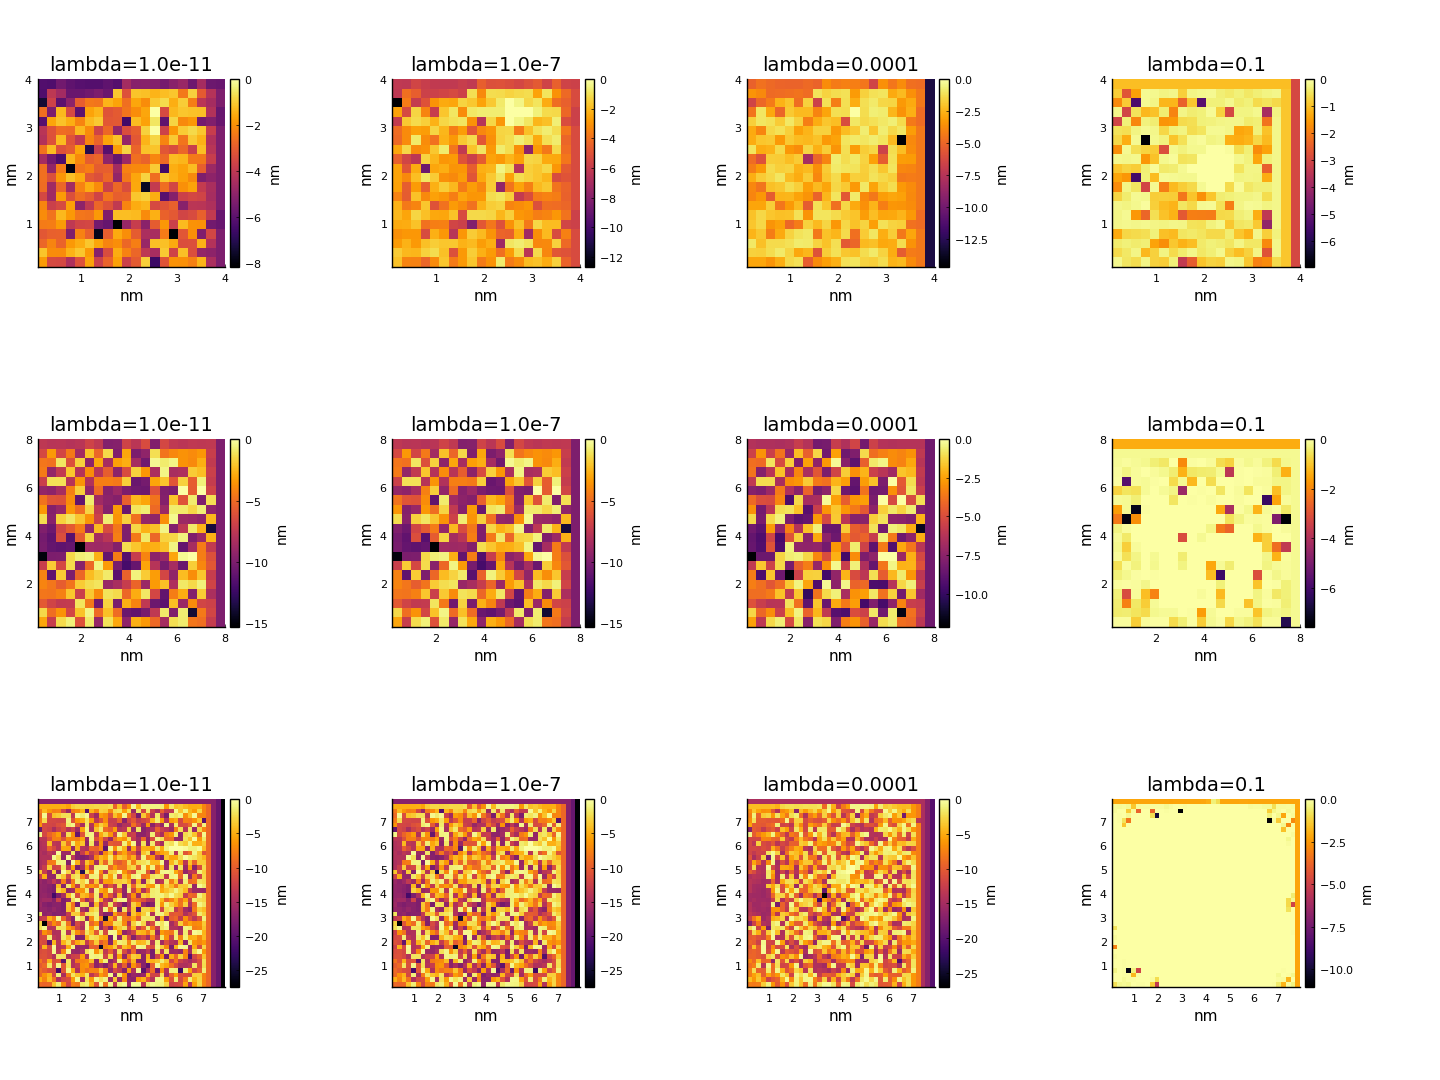

In [45]:
ps = Vector{Plots.Plot}(undef, 12)

titles = ["grid size:20, D.S. ratio:1", "grid size:20, D.S. ratio:2", "grid size:40, D.S. ratio:1"]
for (i, results) in enumerate([normalResults, downScaledResults, largeGridResults])
    row=(i-1)*4
#     results_tmp = [results[1], results[4], results[8], results[12]]
    results_tmp = results
    for (j, result) in enumerate(results_tmp)
        title = "$(titles[i]) (l=$(result.lambda))"
        ps[row+j] = SPM.Plots.heatmap(result.tip; title="lambda=$(result.lambda)")
    end
end
plot(ps..., layout=(3,4), size=(1440, 1080))

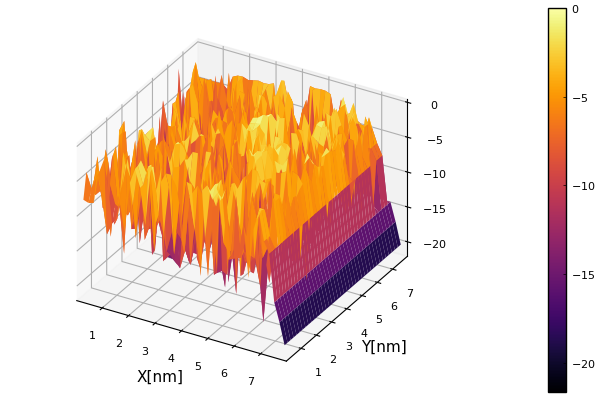

In [47]:
rec_tmp = deepcopy(largeGridResults[3].tip.data)
rec_tmp[rec_tmp .< -25.0] .= NaN
width = size(rec_tmp,1)
resolution = largeGridResults[1].tip.resolution
plot(
    collect(1:width) .* resolution, collect(1:width) .* resolution, rec_tmp,
    st=:surface, xlabel="X[nm]", ylabel="Y[nm]"
)

[ Info: size:(512, 512)   resolution:0.4
[ Info: Matrix{Float32}


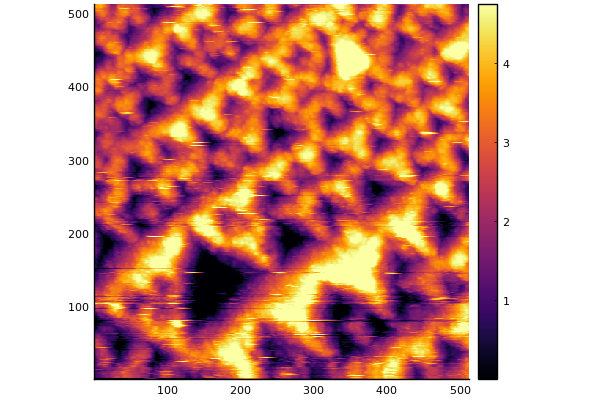

In [78]:
image = SPM.HDR.loadHDR("../data/20001.hdr")
@info "size:$(size(image.data))   resolution:$(image.resolution)"
# SPM.Plots.heatmap(image; legend=true)
@info typeof(image.data)
Plots.heatmap(image.data; aspectratio=:equal)

[ Info: (100, 100)


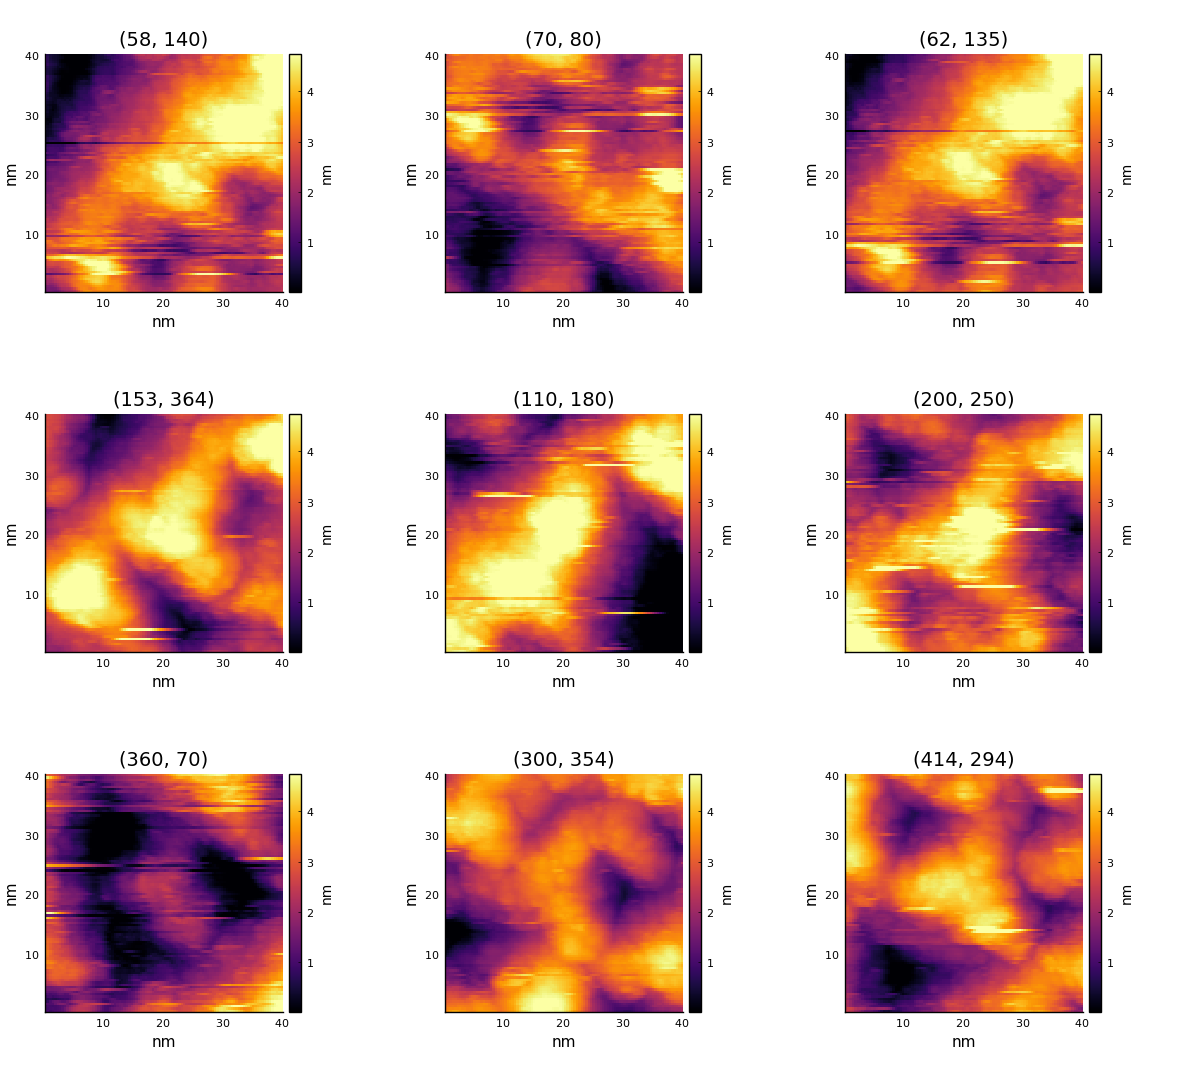

In [79]:
halfwidth = 50
extract_size = (2*halfwidth, 2*halfwidth)
centers = [
    (58,140), (70,80), (62,135), 
    (153,364), (110,180), (200,250), 
    (360,70), (300,354), (414,294)
]
lowerlefts = [(p[1]-halfwidth, p[2]-halfwidth) for p in centers]
plots = Vector{Plots.Plot}(undef, length(lowerlefts))
extracted_images = SPM.extract(image, lowerlefts, extract_size)
for i = eachindex(lowerlefts)
#     plots[i] = Plots.heatmap(extracted_images[i].data; title="$(centers[i])", aspectratio=:equal)
    plots[i] = SPM.Plots.heatmap(extracted_images[i]; title="$(centers[i])")
end

@info size(extracted_images[1].data)
plot(plots..., layout=(3,3), size=(1200, 1080))

In [80]:
downscale_ratio = 1
tip_size = 30
max_epoch = 60
# lambdas = [1.0e-11, 1.0e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
lambdas = [1.0e-11, 1e-8, 1e-5, 1e-2]
@time normalResults = SPM.BTR.solveDifferentiableBTR(
    extracted_images, tip_size, max_epoch, lambdas; need_loss_minimizing=true, downscale_ratio=downscale_ratio
)
@info "finished"
# SPM.BTR.saveResults(extracted_images, normalResults, "normalResults_sharp_tip")

[ Info: 4th thread : start solving for lambda = 1.0e-5
[ Info: 1th thread : start solving for lambda = 0.01
[ Info: 3th thread : start solving for lambda = 1.0e-11
[ Info: 2th thread : start solving for lambda = 1.0e-8
[ Info: 3th thread : optimizer setup completed
[ Info: 4th thread : optimizer setup completed
[ Info: 1th thread : optimizer setup completed
[ Info: 2th thread : optimizer setup completed
[ Info: 2th thread : 20th epoch completed in 17.073 sec
[ Info: 1th thread : 20th epoch completed in 17.204 sec
[ Info: 3th thread : 20th epoch completed in 17.141 sec
[ Info: 2th thread : 20th epoch completed in 17.718 sec
[ Info: 2th thread : 40th epoch completed in 33.186 sec
[ Info: 1th thread : 40th epoch completed in 33.53 sec
[ Info: 2th thread : 40th epoch completed in 33.542 sec
[ Info: 1th thread : 40th epoch completed in 33.984 sec
[ Info: 3th thread : 60th epoch completed in 49.296 sec
[ Info: 1th thread : 1th lambda completed


 50.186820 seconds (7.73 M allocations: 10.055 GiB, 9.18% gc time, 1.99% compilation time)


[ Info: 3th thread : 60th epoch completed in 49.826 sec
[ Info: 3th thread : 2th lambda completed
[ Info: 4th thread : 60th epoch completed in 49.849 sec
[ Info: 4th thread : 4th lambda completed
[ Info: 2th thread : 60th epoch completed in 49.912 sec
[ Info: 2th thread : 3th lambda completed
[ Info: finished


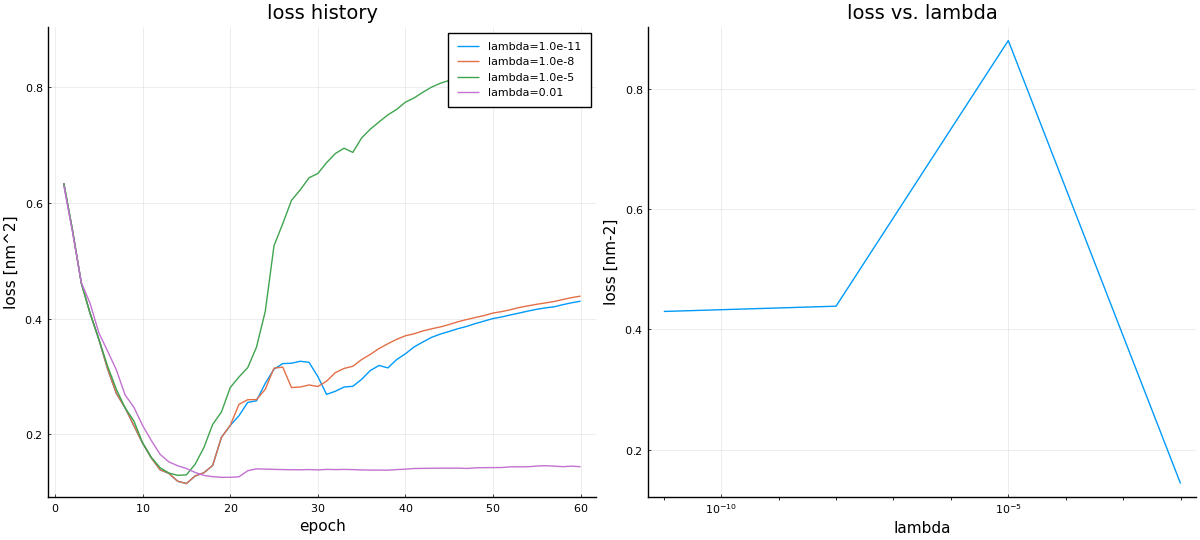

In [81]:
ps = Vector{Plots.Plot}(undef, 2)
ps[1] = plot(xlabel="epoch", ylabel="loss [nm^2]", title="loss history")
for it in eachindex(lambdas)
    plot!(ps[1], collect(1:max_epoch), normalResults[it].loss_history, label="lambda=$(lambdas[it])")
end
ps[2] = plot(
    lambdas, [result.loss_history[end] for result in normalResults],
    xaxis=:log, xlabel="lambda", ylabel="loss [nm-2]", title="loss vs. lambda", legend=nothing
)
plot(ps..., layout=(1,2), size=(1200, 540))

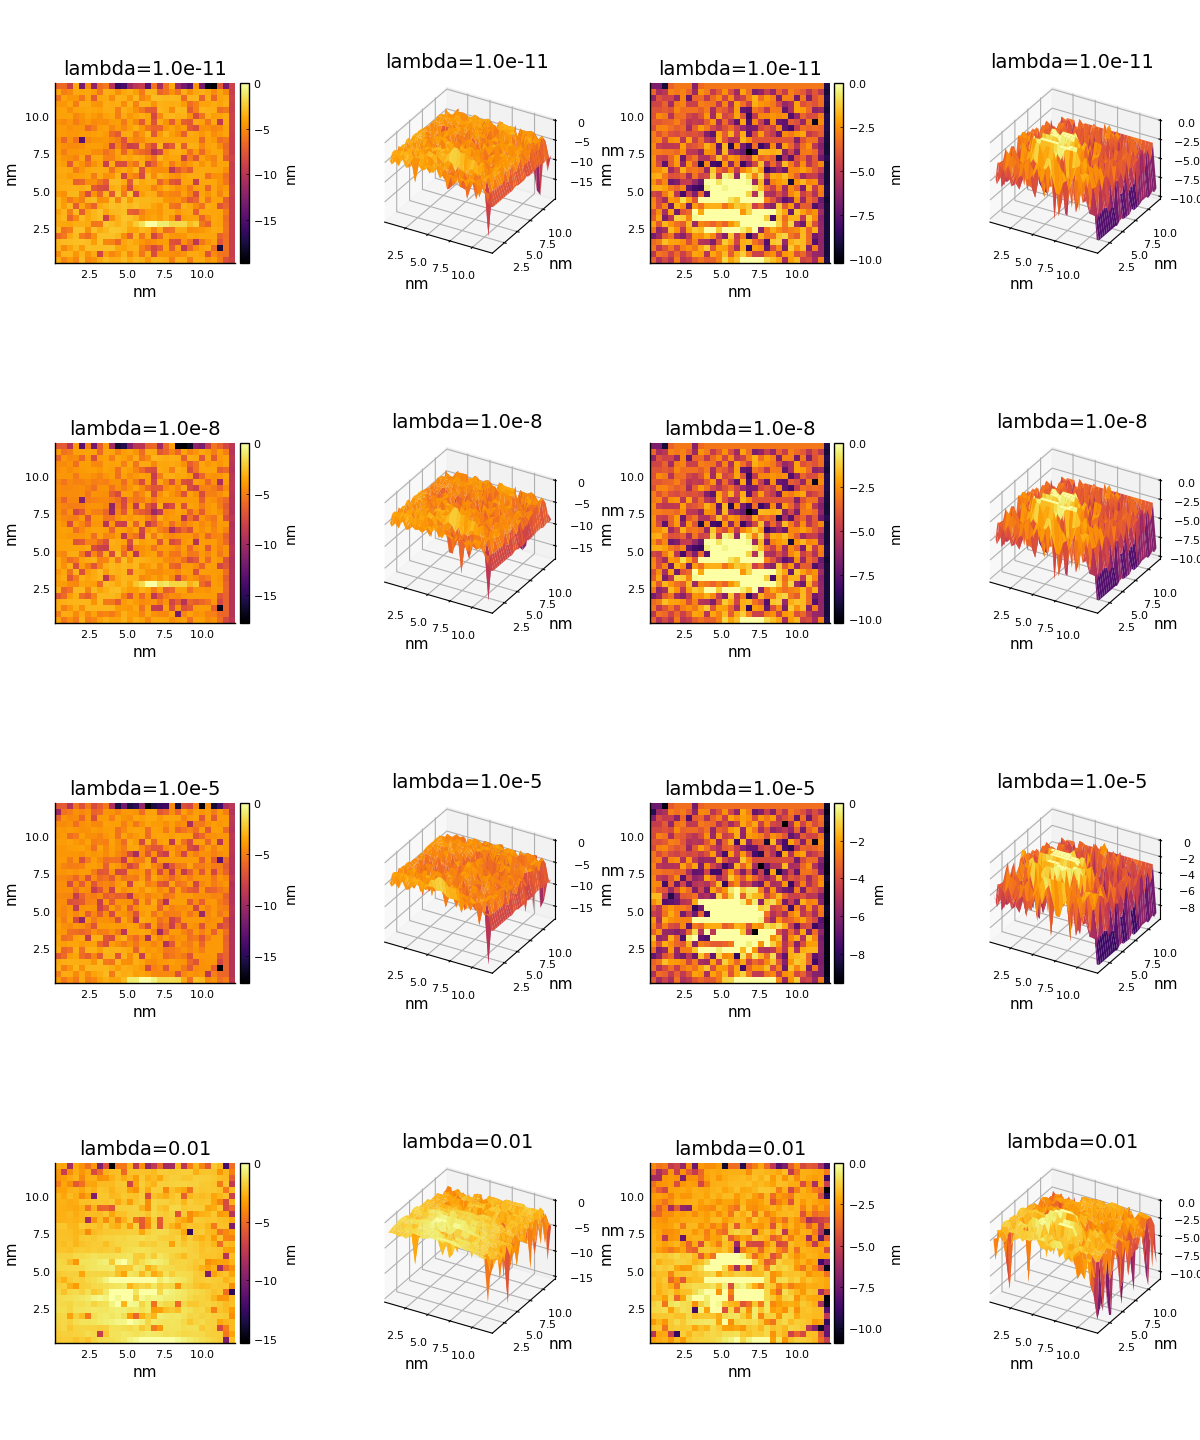

In [82]:
ps = Vector{Plots.Plot}(undef, 16)
for (i, result) in enumerate(normalResults)
    tip = result.tip
    ps[4i-3] = SPM.Plots.heatmap(tip, title="lambda=$(result.lambda)")
    x_mesh = collect(1:size(tip.data, 2)) .* tip.resolution * SPM.DEFAULT_UNIT
    y_mesh = collect(1:size(tip.data, 1)) .* tip.resolution * SPM.DEFAULT_UNIT
    ps[4i-2] = plot(
        x_mesh, y_mesh, tip.data .* SPM.DEFAULT_UNIT,
        st=:surface, title="lambda=$(result.lambda)", legend=nothing
    )
    tip = result.loss_minimizing_tip
    ps[4i-1] = SPM.Plots.heatmap(tip, title="lambda=$(result.lambda)")
    x_mesh = collect(1:size(tip.data, 2)) .* tip.resolution * SPM.DEFAULT_UNIT
    y_mesh = collect(1:size(tip.data, 1)) .* tip.resolution * SPM.DEFAULT_UNIT
    ps[4i] = plot(
        x_mesh, y_mesh, tip.data .* SPM.DEFAULT_UNIT,
        st=:surface, title="lambda=$(result.lambda)", legend=nothing
    )
end
plot(ps..., layout=(4,4), size=(1200, 1440))